In [1]:
import pandas as pd
import re

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
val = pd.read_csv("data/valid.csv")

In [4]:
def build_classifier_model(number_classes):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(number_classes, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [11]:
image = 0
def execute_model(X_train, y_train, X_val, y_val, X_test, y_test, epochs):

    #we use label encoding to convert text labels to numeric, we go from ineffective -> 0 for example


    #we then need to convert the values to tensors, ensuring that the values are converted to strings.
    X_train = tf.convert_to_tensor(X_train.map(str))
    y_train = tf.convert_to_tensor(y_train)
    X_val = tf.convert_to_tensor(X_val.map(str))
    y_val = tf.convert_to_tensor(y_val)
    X_test = tf.convert_to_tensor(X_test.map(str))
    y_test = tf.convert_to_tensor(y_test)

    #extract the number of classes
    number_classes = len(set(y_train.numpy()))

    #build the model
    classifier_model = build_classifier_model(number_classes)
    #we use adam optimizer, as it is an industry standard, and the loss as sparse categorical crossentropy, as our labels are not one-hot encoded.
    classifier_model.compile(optimizer="adam",
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    #we can then train the model
    print(f'Training model:')
    history = classifier_model.fit(X_train, y_train, validation_data = (X_val, y_val),
                               epochs=epochs)


    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.show()
    plt.savefig("bert-10-loss.png")


    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='valid')
    plt.legend()
    plt.show()
    plt.savefig("bert-10-acc.png")
    #evaluate the model
    print("Evaluating accuracy:")
    loss, accuracy = classifier_model.evaluate(X_test, y_test)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')

    #predict for the test data
    prediction = classifier_model.predict(X_test)
    y_pred = []
    for class_pos in prediction.argmax(axis=1):
        y_pred.append(class_pos)


    #show the f1 score and confusion matrix
    print(f"weighted f1-score:{f1_score(y_test, y_pred, average='weighted')}")

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize = (10,7))
    fig = sns.heatmap(df_cm, annot=True, fmt="d",
            xticklabels=["anger", "joy", "optimism", "sadness"],
            yticklabels=["anger", "joy", "optimism", "sadness"])

    #fig.set(xlabel='Predicted', ylabel='Actual')
    plt.savefig("bert-10-cm.png")

# BERT

In [6]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [7]:
X_train, y_train = train.clean_text, train.label
X_test, y_test = test.clean_text, test.label
X_val, y_val = val.clean_text, val.label

Training model:
Epoch 1/5
102/102 [==============================] - 20s 167ms/step - loss: 1.0237 - acc: 0.5824 - val_loss: 0.8654 - val_acc: 0.6791
Epoch 2/5
102/102 [==============================] - 16s 154ms/step - loss: 0.5838 - acc: 0.7958 - val_loss: 0.9445 - val_acc: 0.6471
Epoch 3/5
102/102 [==============================] - 16s 153ms/step - loss: 0.3506 - acc: 0.8833 - val_loss: 1.0315 - val_acc: 0.6925
Epoch 4/5
102/102 [==============================] - 16s 157ms/step - loss: 0.2258 - acc: 0.9272 - val_loss: 1.2161 - val_acc: 0.6898
Epoch 5/5
102/102 [==============================] - 16s 159ms/step - loss: 0.1610 - acc: 0.9518 - val_loss: 1.2762 - val_acc: 0.6765


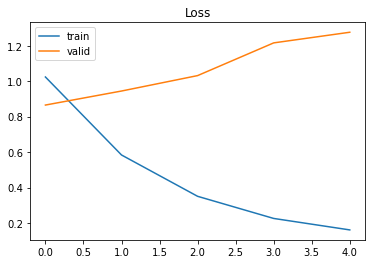

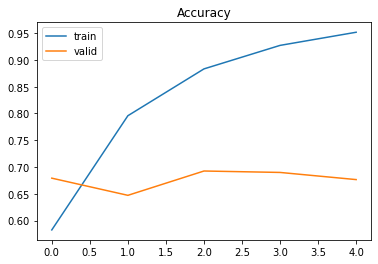

Evaluating accuracy:
45/45 [==============================] - 5s 118ms/step - loss: 1.2809 - acc: 0.6951
Loss: 1.2808703184127808
Accuracy: 0.6950704455375671
weighted f1-score:0.6866797373975445


<Figure size 432x288 with 0 Axes>

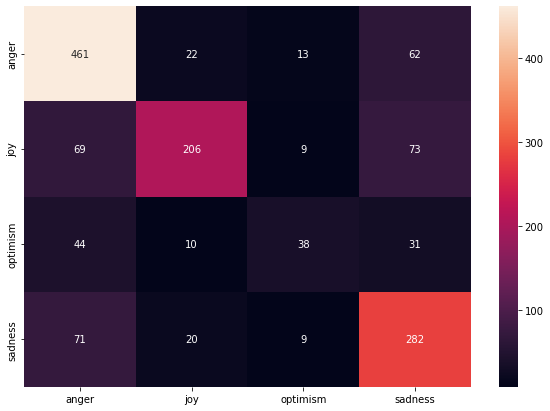

In [10]:
execute_model(X_train, y_train,X_val, y_val, X_test, y_test, 5)

Training model:
Epoch 1/10
102/102 [==============================] - 19s 160ms/step - loss: 1.0408 - acc: 0.5775 - val_loss: 0.8179 - val_acc: 0.6898
Epoch 2/10
102/102 [==============================] - 16s 162ms/step - loss: 0.5718 - acc: 0.8053 - val_loss: 0.8016 - val_acc: 0.7139
Epoch 3/10
102/102 [==============================] - 17s 162ms/step - loss: 0.3407 - acc: 0.8879 - val_loss: 1.0327 - val_acc: 0.6471
Epoch 4/10
102/102 [==============================] - 16s 155ms/step - loss: 0.1960 - acc: 0.9334 - val_loss: 1.2535 - val_acc: 0.6791
Epoch 5/10
102/102 [==============================] - 16s 155ms/step - loss: 0.1289 - acc: 0.9601 - val_loss: 1.3208 - val_acc: 0.6684
Epoch 6/10
102/102 [==============================] - 16s 155ms/step - loss: 0.1039 - acc: 0.9641 - val_loss: 1.6488 - val_acc: 0.6471
Epoch 7/10
102/102 [==============================] - 16s 162ms/step - loss: 0.0895 - acc: 0.9714 - val_loss: 1.5734 - val_acc: 0.6738
Epoch 8/10
102/102 [===================

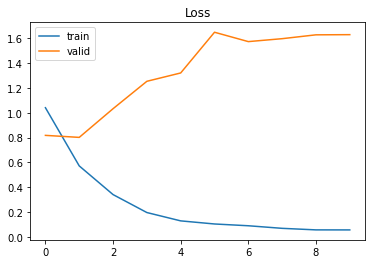

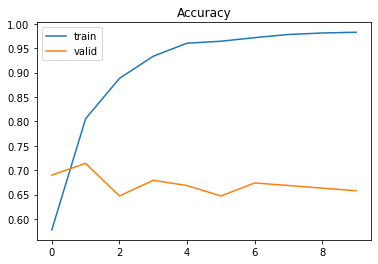

Evaluating accuracy:
45/45 [==============================] - 5s 116ms/step - loss: 1.6279 - acc: 0.6845
Loss: 1.627909779548645
Accuracy: 0.6845070719718933
weighted f1-score:0.6895483049417358


<Figure size 432x288 with 0 Axes>

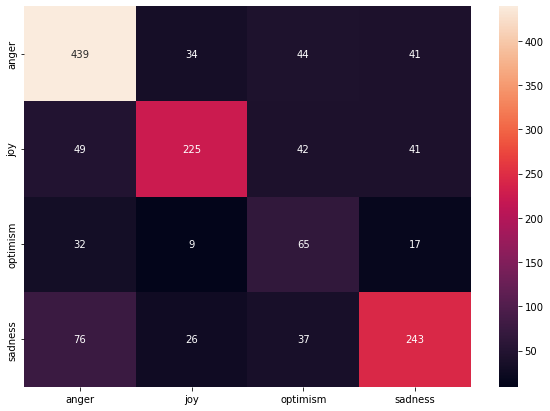

In [12]:
execute_model(X_train, y_train,X_val, y_val, X_test, y_test, 10)